# Bayesian Data Analysis Project: U.S. Births
### DTU, 2018
### Team Members: Inon Peled, Niklas Christopher Petersen, Mads Paulsen. 

# Introduction
TODO: The introduction is inviting, presents an overview of the notebook. Information is relevant and presented in a logical order. The notebook presents a clear cohesive data analysis story, which is enjoyable to read. Structure and organization. What is the data and the analysis problem.

The model can be something already used in the course or something else, but don’t try to do
too complex things. Ther are separate project courses work for more complex models. So mention similarity to some homework models.

### Imports

In [11]:
from matplotlib.ticker import MultipleLocator
from scipy.stats import gaussian_kde
import numpy as np
from datetime import datetime, timedelta

import matplotlib
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 16, 6


import matplotlib.pyplot as plt
# plt.style.use('ggplot')

import pandas as pd

# Data Description

Before fitting prediction models, let us look into the data we have.

In [12]:
births_2000s_df = pd.read_csv('US_births_2000-2014_SSA.csv')
births_2000s_df_with_index = births_2000s_df\
    .rename(columns={'date_of_month': 'day'})\
    .set_index(pd.to_datetime(
        births_2000s_df.rename(columns={'date_of_month': 'day'})
        [['year', 'month', 'day']]))\
    .assign(weekday_name=lambda df: df.index.weekday_name)\
    .assign(day_of_year=lambda df: df.index.dayofyear)\
    .assign(week_of_year=lambda df: df.index.weekofyear)
births_2000s_df_with_index.tail()

,year,month,day,day_of_week,births,weekday_name,day_of_year,week_of_year
2014-12-27,2014,12,27,6,8656,Saturday,361,52
2014-12-28,2014,12,28,7,7724,Sunday,362,52
2014-12-29,2014,12,29,1,12811,Monday,363,1
2014-12-30,2014,12,30,2,13634,Tuesday,364,1
2014-12-31,2014,12,31,3,11990,Wednesday,365,1


We assert that no data imputation is needed.

In [13]:
def num_days_in_year(year):
    return (datetime(year, 12, 31) - datetime(year, 1, 1)).days + 1


def missing_days(df):
    return births_2000s_df_with_index.groupby('year').births.describe()\
        .assign(expected_days=lambda df: list(map(num_days_in_year, df.index)))\
        .assign(missing=lambda df: df.expected_days - df['count'])

        
assert not any(missing_days(births_2000s_df_with_index).missing)

### Distribution Statistics

We next show how births distribute in each year, month, and day of week. We see that whereas the data follows a somewhat steady mean and std. dev. over years and over months, there are is much more variability between days of week:
1. There are numerous outliers in each day of week.
2. There are significantly _less_ births during the weekend (Saturday-Sunday) than during the work week (Monday-Friday).
3. Weekend days have lower variance than work days.

In [14]:
# def show_mean_and_std_by_time_dimension(time_dimension):
#     births_2000s_df_with_index.groupby(time_dimension).births.describe()[['mean', 'std']].plot.bar(fontsize=14)

# list(map(show_mean_and_std_by_time_dimension, ['weekday_name', 'year', 'month']));

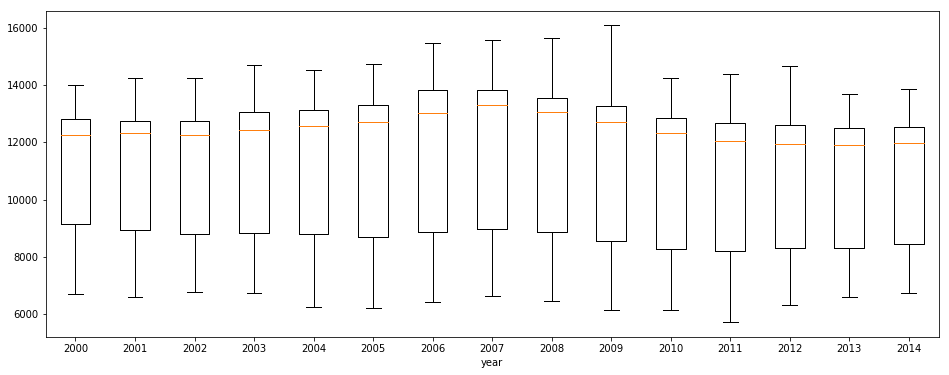

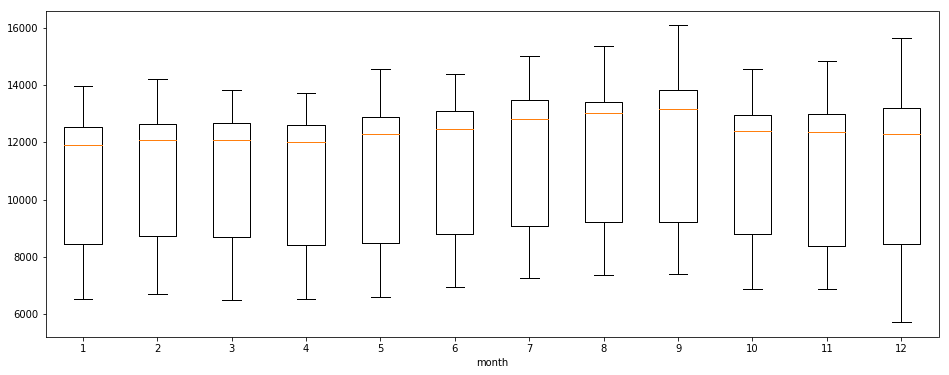

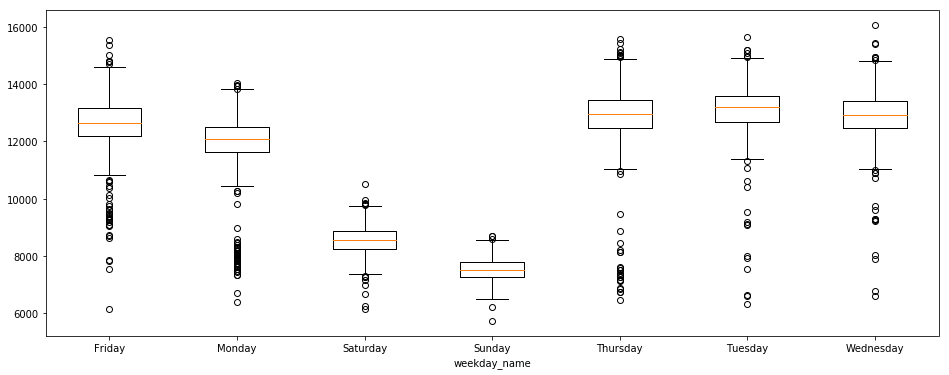

In [15]:
def boxplots(df, time_dimension):
    fig, ax = plt.subplots(1, 1)
    x = sorted(df[time_dimension].unique())
    ax.boxplot([list(df[df[time_dimension] == t].births) for t in x])
    ax.set_xticklabels(x)
    ax.set_xlabel(df[time_dimension].name)

    
for time_dimension in ('year', 'month', 'weekday_name'):
    boxplots(births_2000s_df_with_index, time_dimension)

We also take a look at the distribution of all data points, regardless of time. The distribution is markedly bimodal: one mode for weekend, the other for rest of week. In fact, the weekend distribution is bimodal too, because of differences between Saturday and Sunday.

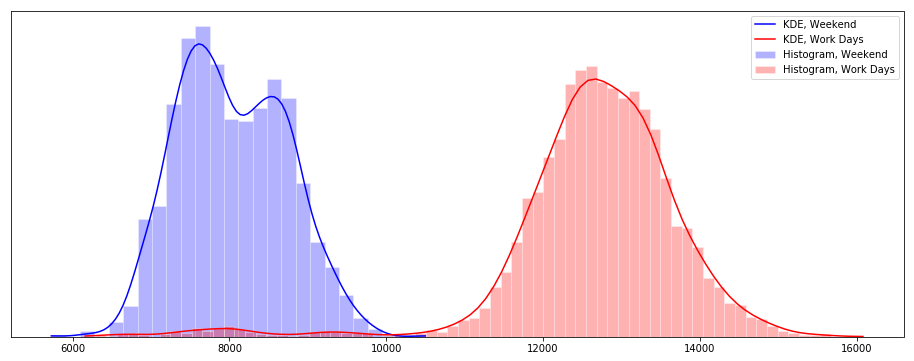

In [16]:
def density_estimation(df):
    fig, ax = plt.subplots(1, 1)
    births_weekend = df.births[df.day_of_week >= 6]
    births_work_days = df.births[df.day_of_week < 6]
    
    ax.hist(births_weekend, bins='auto', facecolor='blue', edgecolor='white', 
            normed=True, label="Histogram, Weekend", alpha=0.3)
    ax.hist(births_work_days, bins='auto', facecolor='red', edgecolor='white', 
            normed=True, label="Histogram, Work Days", alpha=0.3)

    x_kde_weekend = np.linspace(births_weekend.min(), births_weekend.max(), 100)
    ax.plot(x_kde_weekend, gaussian_kde(births_weekend)(x_kde_weekend),
            label="KDE, Weekend", color='blue')

    x_kde_work_days = np.linspace(births_work_days.min(), births_work_days.max(), 100)
    ax.plot(x_kde_work_days, gaussian_kde(births_work_days)(x_kde_work_days), label="KDE, Work Days", color='red')
    
    ax.get_yaxis().set_visible(False)
    ax.legend()
    
density_estimation(births_2000s_df_with_index)

Finally, we turn to look at Gaussian Kernel Density Estimation (KDE) for each weekday separately.

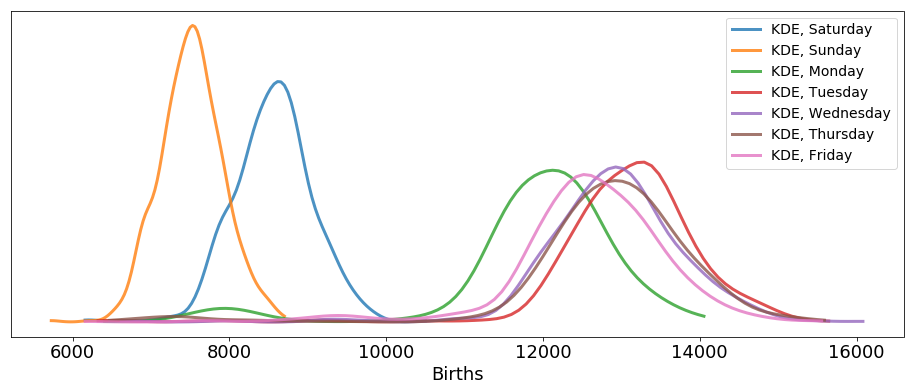

In [38]:
def density_estimation_by_weekday(df):
    fig, ax = plt.subplots(1, 1)
    for d in df.weekday_name.unique():
        daily_births = df.births[df.weekday_name == d]
        x_kde = np.linspace(daily_births.min(), daily_births.max(), 100)
        ax.plot(x_kde, gaussian_kde(daily_births)(x_kde), label="KDE, %s" % d, lw=3)
    ax.get_yaxis().set_visible(False)
    ax.set_xlabel("Births")
    ax.legend(fontsize=14)
    
density_estimation_by_weekday(births_2000s_df_with_index)

## Seasonality
The next few plots are meant to emphasize any obvious seasonality in the time series of births.

First, we see that each year displays are generally similar trend: steady increase in first few months, followed by a peak, a drop, and another peak at end of year.

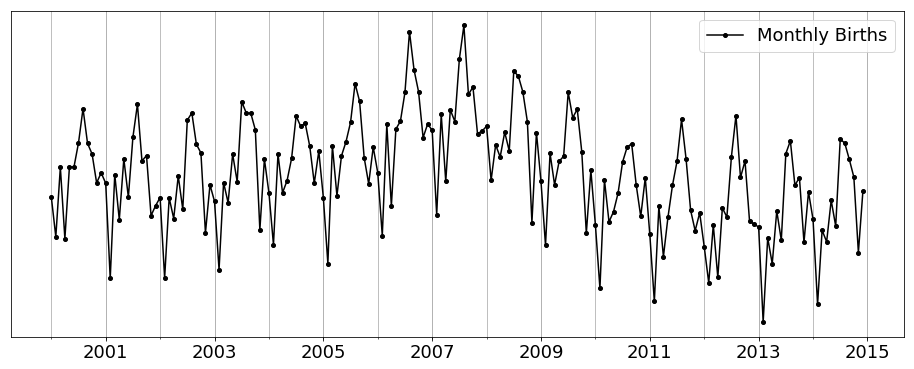

In [36]:
def plot_monthly_births(df):
    d = df.groupby(('year', 'month')).births.sum().reset_index()
    f = pd.to_datetime(d.assign(day=1).drop('births', axis=1))
    ax = d.set_index(f).drop(['year', 'month'], axis=1)\
        .births.rename("Monthly Births")\
        .plot(color="black", marker='o', markersize=4)
    ax.legend()
    ax.grid(which='both')
    ax.get_yaxis().set_visible(False)

plot_monthly_births(births_2000s_df_with_index)

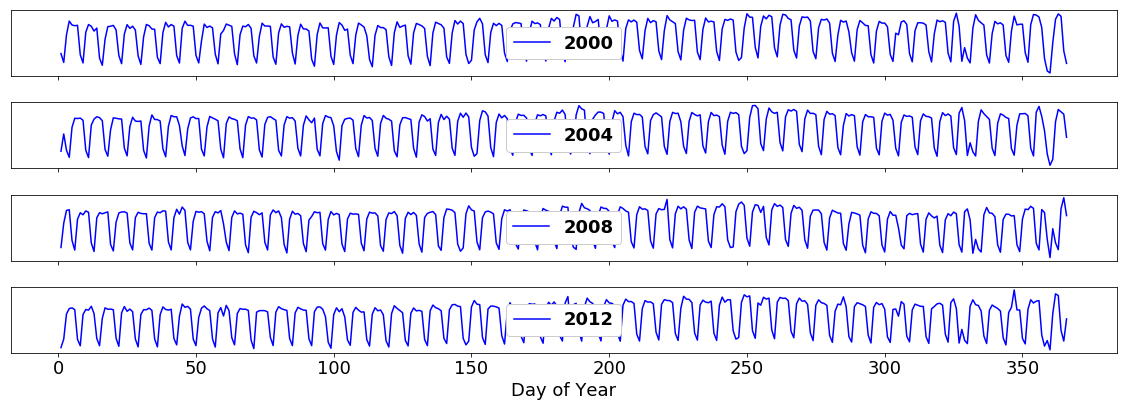

In [19]:
def compare_some_years(years):
    matplotlib.rc('font', **{'size': 18})
    fix, axes = plt.subplots(len(years), 1, sharex=True)
    for i, year in enumerate(years):
        axes[i].plot(
            births_2000s_df_with_index.set_index('day_of_year')[lambda r: r.year == year].births, 
            label=year, color='blue')
        axes[i].legend(prop={'weight':'bold'}, loc='center', framealpha=1)
        axes[i].get_yaxis().set_visible(False)
    axes[-1].set_xlabel("Day of Year")
    plt.tight_layout()
        
compare_some_years(range(2000, 2015, 4))

It is known that people are biased against giving births in some specific dates: holidays, 13th of each month, and 29th Feb. on leap years. However, in this work, we will not involve any contextual information, but rather use only the births data.

# Bayesian Inference Models and Priors

The following describes each Bayesian Inference model we test, along with justifications for choosing such a model, and a definition of the **prior distributions** which the model uses.

### Models Disregarding the Time Series
The plot of KDEs shows that for each weekday, the data distribution resembles a Gaussian. We should thus try several models:
1. Searate Model: for each weekday $d_i, i=1..7$, let the prior be $d_i \sim \mathcal{N}(\mu_i, \sigma_i^2)$, where $\mu_i$ and  $\sigma_i$ are chosen independently of other days, e.g. drawn from a Gaussian which is parameterized on the sample mean and sample variance for  $d_i$.
2. Hierarchical Model: similar to Separate Model, except that all $\mu_i$ and all $\sigma_i$ are each drawn from a shared distribution.
3. Hierarchicial Model for work days, Separate Models for weekend days.

### Models Using the Time Series
Because births are measured daily, we will model the births $y_t$ at day $t$ as following a prior Poisson distribution, with rate determined by data in days up to $t-1$. That is, we model
$$
y_t \sim Poisson \left( exp\left(z_t\right) \right)
$$
where
$$
z_t \sim \mathcal{N}\left(\beta z_{t-1} + \theta^T  x_t, \sigma_t^2\right)
$$
and
$$
x_t = \left(\text{year, month, day-of-month, day-of-week}\right)
$$
The exponent ensures that the Poisson rate is positive, and $\beta, \theta, \sigma_t$ are parameters to be learnt. In accordance with our data analysis, this model is heteroskedastic, i.e. allows a different variance $\sigma_t$ for each $t$.

TODO: Required onvergence diagnostic results (Rhat, neff, divergences) shown and maning of the results is discussed.
TODO: PGM drawings from e.g. ShinyStan?
TODO: A table summarizing the Stan parameters (chains, algorithm, etc.) we use in running each model.

## Separate Model for Each Weekday

# Predictive Performance Assessment
RMSE, MAE, widht of 95% C.I.

# Discussion of Potential Improvements
Discussion of problems and potential improvements:
* Use contextual information, which is known to account for trends in the data.
* Compare to some classic baseline models for time series prediction, e.g. Seasonal ARIMA with exogenous variables.
* More sensitivity analysis for choice of prior. 

# Conclusion
In particular, emphasize one main conclusion.